# VITO ENiGMA VANDLE simulations

Quick simulation of VANDLE response using Xu's response function for 132Cd data

In [1]:
include("/Users/mmadurga/Library/Mobile Documents/com~apple~CloudDocs/Coding Projects/Utilities/Julia/MonteCarlo.jl")

using Plots,Printf,Distributions,.MonteCarlo


# general physics conditions

c = 30 #cm/ns
mₙ = 998 # MeV/c^2
sₙ = 5146.4529 # 49Ca Sₙ in keV



5146.4529

We take the sampling function for the rest of the code. mcreject implements the  [Monte Carlo rejection method](https://web.tecnico.ulisboa.pt/~mcasquilho/acad/theo/simul/Vujic.pdf) to create a sample of $N_s$ elements from an arbitrary univariate PDF (`pdf`) in given `xmin->xmax+xmin` and `0->ymax` ranges.

## VANDLE conditions

First we define the conditions (efficiency, distance, number of bars, etc) for VANDLE

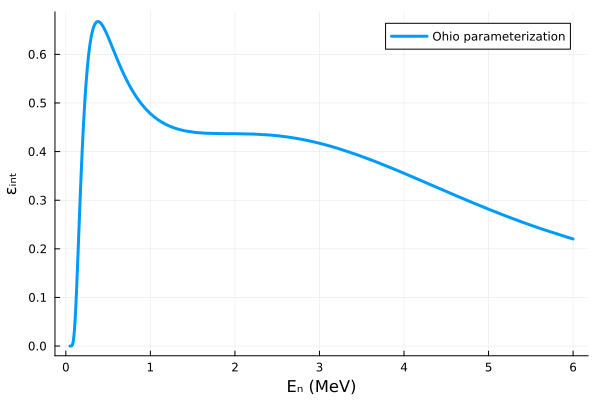

In [2]:

parameterization=[1.67952, -0.33499, 0.677482, 0.834834, 
                -2.41166, -1.52589, 0.893949, 1.39871]

εᵥ = e -> 10^(sum(parameterization.*log10(e).^(eachindex(parameterization).-1)))/100 

plot(εᵥ,0.05,6,lw=3,xlabel="Eₙ (MeV)",ylabel="εᵢₙₜ",label="Ohio parameterization")


We calculate the total efficiency from the intrinsic parameterization from Ohio and solid angle subtended by a [centered rectangular surface](https://vixra.org/abs/2001.0603).

$\alpha=a/(2\cdot d)$

$\beta=b/(2\cdot d)$

$\Omega = 4 \cdot \arctan\frac{\alpha\beta}{\sqrt{1+\alpha^2+\beta^2}}$

in stereoradians.  $a$ and $b$ are the rectangle's sides and $d$ is the distance to the observer.

0.16666666666666669

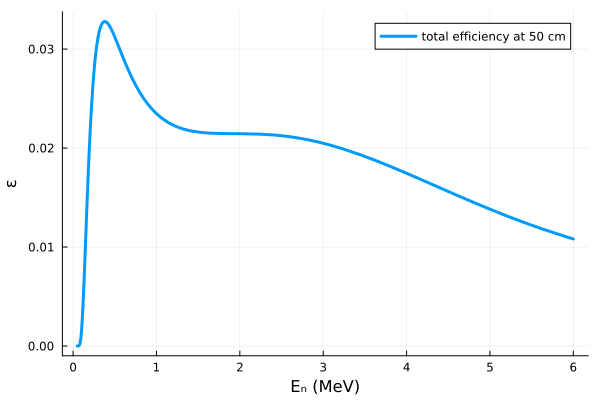

In [3]:
rate = 2.7E5 * 2 #ions/μC times 2 μC max ISOLDE current
numberofdecays = rate * 3600 * 8 #decays per 8 h shift

numberofbars = 30
numberofbetadetectors = 2

# Ωᵥ = distance -> numberofbars * 60 * 3 / (distance^2 * 4 * π)
# Ωᵦ = 2 * 5^2 / (5^2 * 4 * π)

function Ω(width,length,distance)
    α = width/(2*distance)
    β = length/(2*distance)
     return  4*atan(α*β / sqrt(1+α^2+β^2)  ) / (4*π)
end 

display(Ω(5,5,2.5))

ε(e,d) =  εᵥ(e) * numberofbars * Ω(3,60,d) * numberofbetadetectors * Ω(5,5,2.5)

plot(e->ε(e,50),0.05,6,lw=3,xlabel="Eₙ (MeV)",ylabel="ε",label="total efficiency at 50 cm")

## Defining the response function

We use the response function Xu prepared for $^{132}Cd$'s 2015 dataset. It follows the three stage function I originally made for $^{84}Ga$ with parameter corrections to reproduce the $^{49}K$ data from 2015.

The original FORTRAN version is under 

`/Users/mmadurga/Documents/Ubuntu/Analysis/VANDLE/Cd132_analysis/Fit/`

The resolution is fitted to 100 cm, so we can approximate the resolution for other distances using

$\frac{\sigma t}{t}=2\cdot\frac{\sigma x}{x}$

therefore, when $\sigma x'=\sigma x=$ width and $x' = x \cdot n$, with $x=100$ cm, then

 $\frac{\sigma t'}{t'} = 2\cdot\frac{\sigma x'}{x'}= 2\cdot\frac{x}{x'}\cdot\frac{\sigma x}{x} = 2\cdot \frac{1}{n}\cdot \frac{\sigma x}{x}$

In [4]:
function xuresponsefit(t,inputarea,Tₒ,distance)

    Area=Array{Float32,1}(undef,5)

# parameters

    σₒ = (243432. *Tₒ^2. - 11635843. *Tₒ + 736628549.)*1.E-9 
    Aₒ = (0.2*(9961. *Tₒ^2. - 2271025. *Tₒ + 169902047.))*1.E-9
    σ1 = -(32635. *Tₒ^2. + 29611564. *Tₒ - 330764765.)*1E-9
    k1 = (1.3*(3183. *Tₒ^2. - 814553. *Tₒ + 156450993.))*1.E-9
    d1 = (0.65*(71025. *Tₒ^2. - 21045104. *Tₒ + 3969567038.))*1.E-9
    k2 = (1.3*(-1410. *Tₒ^2. + 620420. *Tₒ + 10475713.))*1.E-9
    d2 = (0.7*(79669297. *Tₒ + 11267453221.))*1.E-9
    k3 = (-988. * Tₒ^2. + 315032. * Tₒ - 4530112.)*1.E-9
    d3 = (22333042. * Tₒ^2. - 6632270383. * Tₒ + 539757365929.)*1.E-9

    σEx = (283600. * Tₒ^2. - 1663115. * Tₒ + 681358889.)*1.E-9

    σₒₚ  = sqrt(σₒ^2. +σEx^2.) * 100/distance
    σ₁ₚ = sqrt(σ1^2. +σEx^2.) * 100/distance
    
    b1 = exp(k1*(k1+d1))/(1+(k1+d1)^2.)
    b2 = exp(k1*(k1+d1)-(k1-k2)*(k2+d2))/(1+(k1+d1)^2.)
    b3 = exp(k1*(k1+d1)-(k1-k2)*(k2+d2)-(k2-k3)*(k3+d3))/(1+(k1+d1)^2.)



# conditional variable

    xx = (t-Tₒ)/σ₁ₚ
    
# Calculate Normalization Area 

    Area[1] = -σₒₚ *sqrt(Aₒ)+(1+Aₒ)*σₒₚ *atan(1/sqrt(Aₒ))
    Area[2] = σ₁ₚ * atan(k1+d1)
    Area[3] = σ₁ₚ*(1. -exp(k1*(d1-d2+k1-k2))/(k1*(1. +d1^2. +2. *d1*k1+k1^2.)))
    Area[4] = σ₁ₚ * exp((k1*(d1-d2+k1-k2)-d3*k2-k2*k3))/(k2*(1+d1^2. +2. *d1*k1+k1^2.))*(exp(k2*(d3+k3))-exp(k2*(d2+k2)))
    Area[5] = σ₁ₚ * exp(d1*k1-d2*k1+k1^2+d2*k2-d3*k2-k1*k2+k2^2. -k2*k3)/(k3*(1. +d1^2. +2. *d1*k1+k1^2.))
    
    Norm = sum(Area)
    response = 0.

    # Response Function

    if ((-1/sqrt(Aₒ) <= xx)&&(xx<=0)) 

       response = inputarea * 1. /Norm * (σₒₚ ^2/((t-Tₒ)^2. +σₒₚ ^2.) * (Aₒ+1) - Aₒ )
    
    elseif ((0<xx)&&(xx<=(k1+d1))) 
       
       response = inputarea * 1. /Norm *  σ₁ₚ^2/((t-Tₒ)^2. +σ₁ₚ^2.)
       
    elseif (((k1+d1)<xx)&&(xx<=(k2+d2))) 
       
       response = inputarea * 1. /Norm*b1*exp(-k1*xx)
       
    elseif (((k2+d2)<xx)&&(xx<=(k3+d3))) 
       
       response = inputarea * 1. /Norm*b2*exp(-k2*xx)
       
    elseif (xx>(k3+d3)) then

       response = inputarea * 1. /Norm*b3*exp(-k3*xx)

    end
    
    return response

    end


xuresponsefit (generic function with 1 method)

We plot an example of a 1 MeV peak (~74 ns) at 100 cm

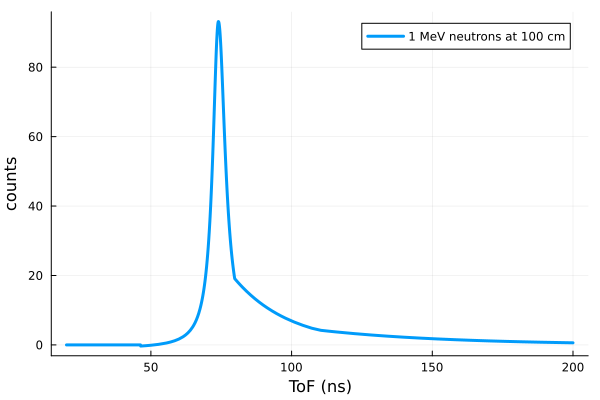

In [5]:
plot(t->xuresponsefit(t,1000,74,100),20,200,
lw=3,xlabel="ToF (ns)",ylabel="counts",label="1 MeV neutrons at 100 cm")

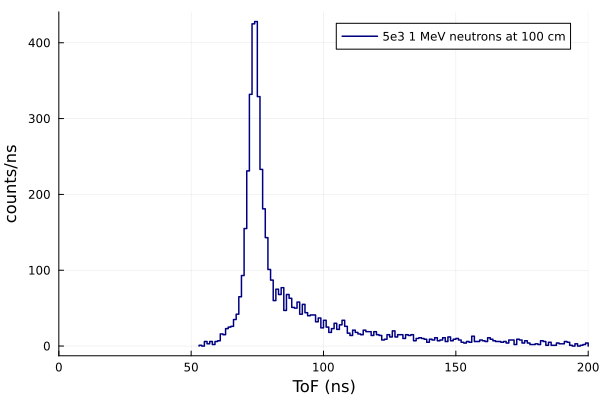

In [6]:
samp=MonteCarlo.mcreject(1,0,200,5e3,t->xuresponsefit(t,1,74,100))
plot(samp,seriestype=:stephist,nbins=200,xlims=(0,200),
color=:navy,lw=1.5,
xlabel="ToF (ns)",ylabel="counts/ns",label="5e3 1 MeV neutrons at 100 cm")

## Defining $^{49}K$ peaks

We define an array with the neutron energies (in MeV) and intensities in the decay of 49K, and calculate the times-of-flight

In [7]:

#     Excitation energy (keV)                  neutron branching ratio (%)
K⁴⁹=[ 5304.95									2.41
5589.76											9.73
5713.48											6.99
6338.60											10.84
6559.91											18.82
6696.75											13.63
6904.00											1.51
7068.11											11.90
7320.98											3.30
7438.17											2.12
7586.00											0.23
7801.00											0.96
8140.00											0.55
8416.65											1.45
8678.00											0.66
9100.00											0.11
9280.00											0.32
9580.00											0.27
10100.00										0.18
]
;
println("Pₙ"  ) 
@printf "%.3f" sum(K⁴⁹[:,2]/100)

Pₙ


0.860

Some calculations that are common to each distance

In [8]:
Eₙ = (K⁴⁹[:,1].- sₙ) .* 48/(49*1000) 

19-element Vector{Float64}:
 0.15526246530612206
 0.4342600163265306
 0.5554551183673463
 1.1678175673469389
 1.3846110367346935
 1.518658383673469
 1.7216787918367344
 1.8824396081632648
 2.1301489959183666
 2.244947363265306
 2.3897604244897956
 2.6003726693877547
 2.9324543020408163
 3.203458383673469
 3.4594747102040815
 3.872862465306122
 4.049188995918367
 4.3430665469387755
 4.852454302040816

Now we calculate the values for 50 cm

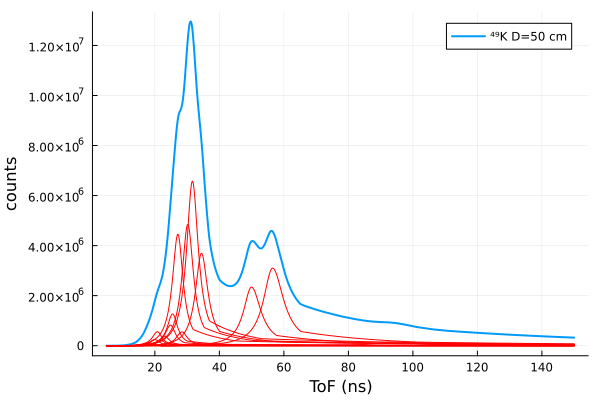

In [9]:
path = 50; 

Iₙ = K⁴⁹[:,2]./100 .* numberofdecays .* ε.(Eₙ,path)

ToF = 1/sqrt(2) * path * sqrt.(mₙ .* Eₙ) ./ (c .* Eₙ)

plot50cm=plot(t->sum(xuresponsefit.(t,Iₙ,ToF,path)),5,150,
lw=2,xlabel="ToF (ns)", ylabel="counts",label="⁴⁹K D=50 cm")

for i in eachindex(Iₙ)
    plot50cm=plot!(t->xuresponsefit(t,Iₙ[i],ToF[i],path),linecolor=:red,label="")
end 
display(plot50cm)

distance 70 cm

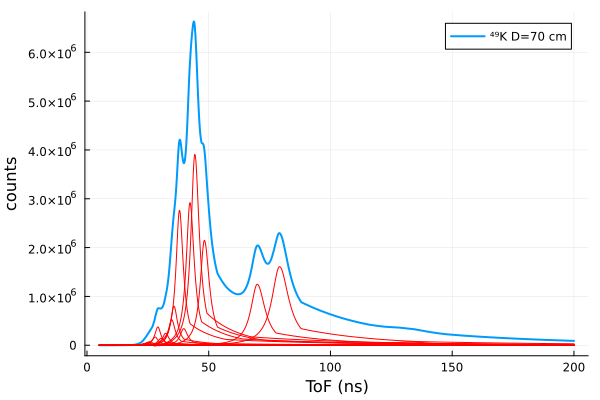

In [10]:
path = 70; 

Iₙ = K⁴⁹[:,2]./100 .* numberofdecays .* ε.(Eₙ,path);

ToF = 1/sqrt(2) * path * sqrt.(mₙ .* Eₙ) ./ (c .* Eₙ)

plot70cm=plot(t->sum(xuresponsefit.(t,Iₙ,ToF,path)),5,200,
lw=2,xlabel="ToF (ns)", ylabel="counts",label="⁴⁹K D=70 cm")


for i in eachindex(Iₙ)
     plot70cm=plot!(t->xuresponsefit(t,Iₙ[i],ToF[i],path),linecolor=:red,label="")
end 
display(plot70cm)



And 100 cm

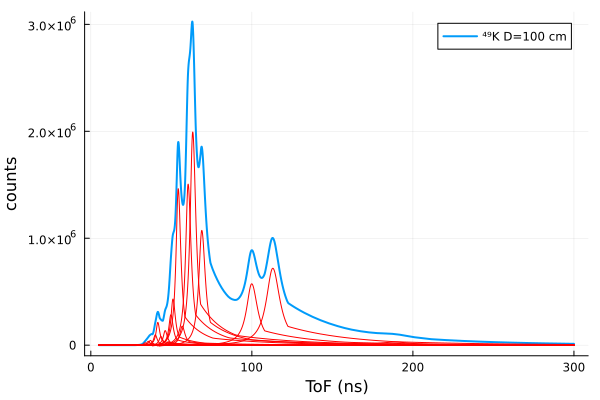

In [11]:
path = 100; 

Iₙ = K⁴⁹[:,2]./100 .* numberofdecays .* ε.(Eₙ,path)

ToF = 1/sqrt(2) * path * sqrt.(mₙ .* Eₙ) ./ (c .* Eₙ)


plot100cm=plot(t->sum(xuresponsefit.(t,Iₙ,ToF,path)),5,300,
lw=2,xlabel="ToF (ns)", ylabel="counts",label="⁴⁹K D=100 cm")

for i in eachindex(Iₙ)
    plot100cm=plot!(t->xuresponsefit(t,Iₙ[i],ToF[i],path),linecolor=:red,
    label="")
end 
display(plot100cm)



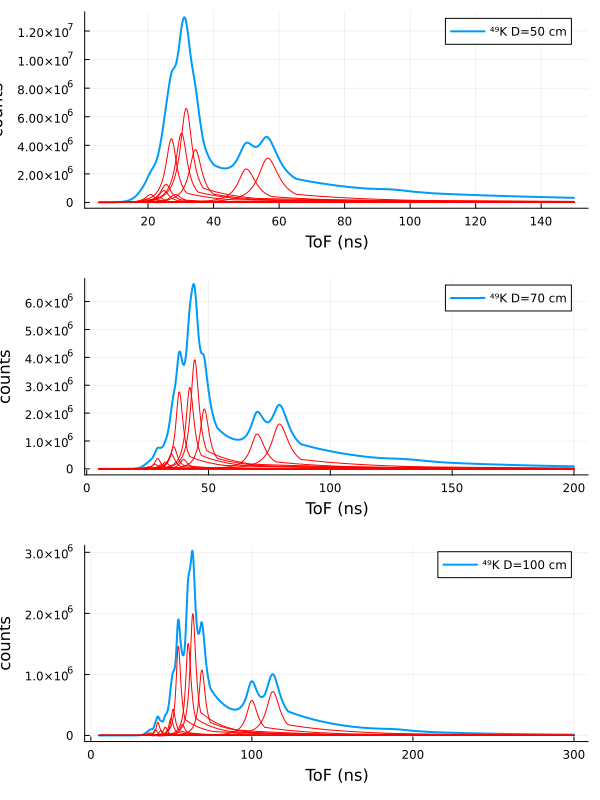

In [12]:

final=plot(plot50cm,plot70cm,plot100cm, size = (600,800),
layout=@layout [a; b; c])
savefig("K49Resolutions.pdf")
display(final)

## Monte Carlo Samples

We calculate a sample from the PDF defined by `xuresponsefit` using the basic Monte Carlo rejection method in `mcreject`
### K-49

First we need to plot the function to define the boundary of the Monte-Carlo area

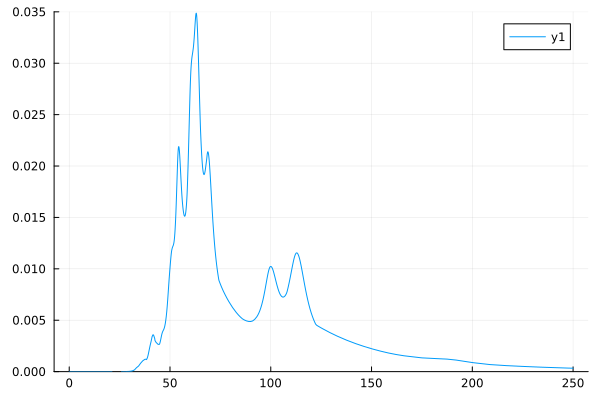

In [13]:
path = 100;

Iₙ = K⁴⁹[:,2]./100 .* numberofdecays .* ε.(Eₙ,path)

ToF = 1/sqrt(2) * path * sqrt.(mₙ .* Eₙ) ./ (c .* Eₙ)

plot(t->sum(xuresponsefit.(t,Iₙ./sum(Iₙ),ToF,path)),0,250,ylims=(0,0.035))

In [14]:
ymax = 0.035; tmin = 25; tmax = 250 ; Nₛ49=1e6 ; #Np=2.7e5*2*3600*8*ε(1,100)*sum(K⁴⁹[:,2]./100); print(Np)

sampleK49=MonteCarlo.mcreject(ymax,tmin,tmax,Nₛ49,t->sum(xuresponsefit.(t,Iₙ./sum(Iₙ),ToF,path)));


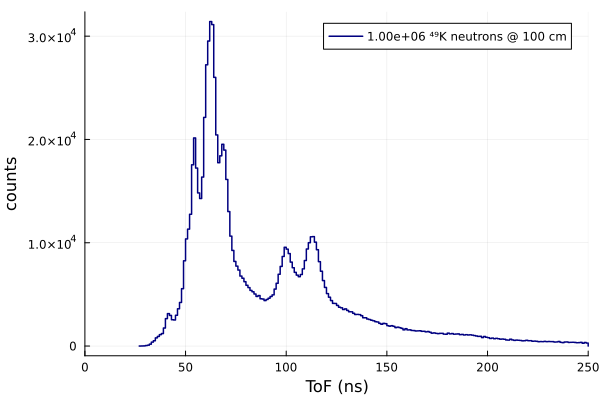

In [15]:
tmin = 25; tmax = 250 
N= @sprintf "%.2e" Nₛ49
plot(sampleK49,seriestype=:stephist,nbins=tmax,xlims=(0,tmax),
color=:navy,lw=1.5,xlabel="ToF (ns)",ylabel="counts",label=N*" ⁴⁹K neutrons @ 100 cm")

Let us quickly calculate the distribution for 50 cm.

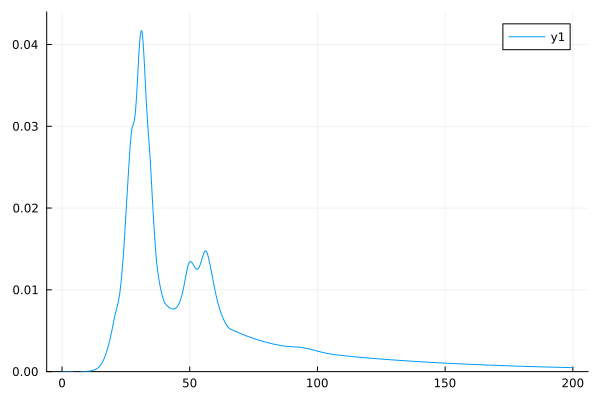

In [16]:
path=50
ToF50cmK49 = 1/sqrt(2) * path * sqrt.(mₙ .* Eₙ) ./ (c .* Eₙ)

plot(t->sum(xuresponsefit.(t,Iₙ./sum(Iₙ),ToF50cmK49,path)),0,200,ylims=(0,0.044))

In [17]:
ymax = 0.044; tmin = 15; tmax = 125; Nₛ49=1e5 #actual rate per shift is too high to quickly simulat with MC

sample50cmK49=MonteCarlo.mcreject(ymax,tmin,tmax,Nₛ49,
t->sum(xuresponsefit.(t,Iₙ./sum(Iₙ),ToF50cmK49,path)));

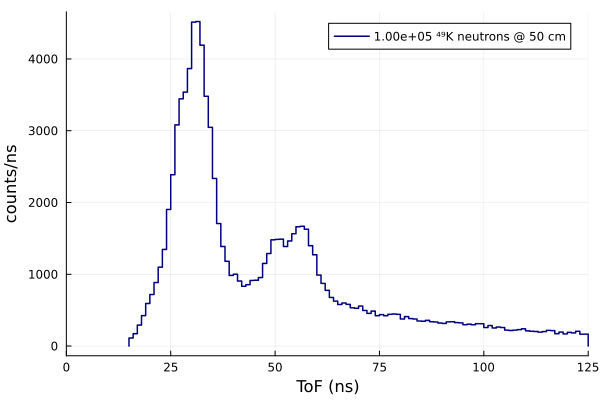

In [18]:
tmin = 15; tmax = 125 
N = @sprintf "%.2e" Nₛ49
plot(sample50cmK49,seriestype=:stephist,nbins=tmax,xlims=(0,tmax),
color=:navy,lw=1.5,xlabel="ToF (ns)",ylabel="counts/ns",label=N*" ⁴⁹K neutrons @ 50 cm")

### K-51
We repeat the excercise for $^{51}K$ using the energies and branching ratios from Perrot's paper

In [19]:
#       Eₙ (keV) neutron branching ratio
K51 = [820	0.019024559
910	0.031822899
1170	0.076098236
1540	0.074714632
2190	0.042891733
3070	0.025250778
3670	0.019024559
530	0.001729505
780	0.007955725
980	0.015911449
1470	0.004842615
1840	0.007955725
2570	0.00311311
690	0.004842615
960	0.004842615
1460	0.007955725
2270	0.004842615
830	0.006226219
1420	0.00311311
1990	0.00311311
840	0.218263577
2230	0.345901072
3290	0.035281909
4200	0.017640955
4860	0.017640955];

println("Pₙ")
@printf "%.3f" sum(K51[:,2])*0.218

Pₙ
0.218

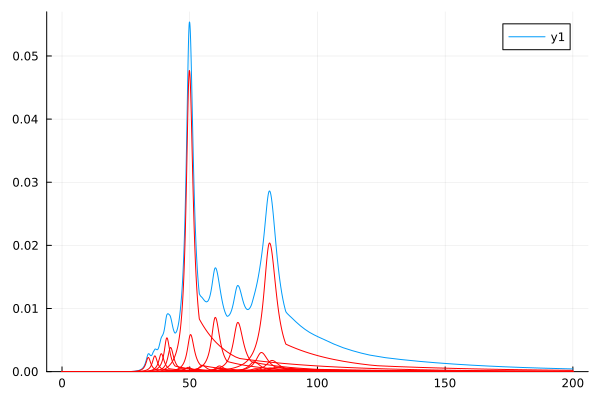

In [20]:
path = 100;
Eₙ51 = K51[:,1]./1000
Iₙ51 = K51[:,2] .* ε.(Eₙ51,path)

ToF51 = 1/sqrt(2) * path * sqrt.(mₙ .* Eₙ51) ./ (c .* Eₙ51)

plotK51=plot(t->sum(xuresponsefit.(t,Iₙ51./sum(Iₙ51),ToF51,path)),0,200,ylims=(0,0.057))

for i in eachindex(ToF51)
    plotK51=plot!(t->xuresponsefit(t,Iₙ51[i]/sum(Iₙ51),ToF51[i],path),
    linecolor=:red,label="")
end
display(plotK51)

In [21]:
Nₛ51 = 4.5e3 * 2 * 3600 * 8 * ε(1,100) * 0.218 #rate/μC * 2μC * 1shift * efficiency at 1 MeV * neutron branching ratio
print(Nₛ51)
ymax = 0.055; tmin = 25; tmax = 150; 

sampleK51=MonteCarlo.mcreject(ymax,tmin,tmax,Nₛ51,
t->sum(xuresponsefit.(t,Iₙ51./sum(Iₙ51),ToF51,path)));


370606.792397056

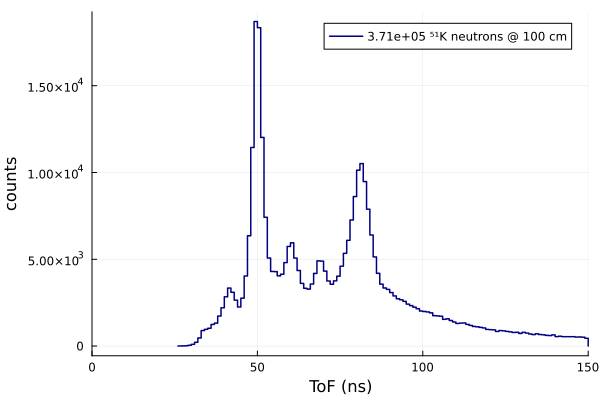

In [22]:
tmin = 25; tmax = 150

N = @sprintf "%.2e" Nₛ51
plot(sampleK51,seriestype=:stephist,nbins=tmax,xlims=(0,tmax),
color=:navy,lw=1.5,xlabel="ToF (ns)",ylabel="counts",label=N*" ⁵¹K neutrons @ 100 cm")